In [1]:
from util.lexicon_dataloader import LexiconDataLoader
from util.corpus_dataloader import CorpusDataLoader
from model.lexicon_model_new import Lexicon, LexiconParams, LexiconModel

In [2]:
LEXICON_PATH = "data/VnEmoLex.xlsx"
CORPUS_PATH = "data/corpus.csv"

In [3]:
lexicon = LexiconDataLoader(LEXICON_PATH)
corpus = CorpusDataLoader(CORPUS_PATH, limit=100)

Lexicon loaded: 10626 words.
Corpus loaded: 100 records.


In [4]:
lexicon_dict = lexicon.data
print(lexicon_dict.get('tin'))

{'english': 'believed', 'positive': 0, 'negative': 0, 'anger': 0, 'anticipation': 0, 'disgust': 0, 'fear': 0, 'joy': 0, 'sadness': 0, 'surprise': 0, 'trust': 1, 'sum': 1, 'id': 5963}


In [5]:
corpus.add_tokenized_column()
corpus_dataframe = corpus.data
print(corpus.data.head())

Tokenizing lyrics column...
Tokenization complete.
Added 'lyrics_tokenized' column to dataframe.
  title               composers                    lyricists  year  \
0    10                ['DTAP']                     ['DTAP']  2017   
1    12  ['Hoàng Tôn', 'Mr. A']       ['Hoàng Tôn', 'Mr. A']  2013   
2    15     ['Nguyen Bao Tung']  ['Tùng', 'Nguyen Bao Tung']  2025   
3    20           ['Thanh Duy']                ['Thanh Duy']  2003   
4    22               ['Trang']                    ['Trang']  2020   

            genres                                             lyrics  \
0               []  lâu nay bên nhau, ta đâu giống trò chơi đâu sa...   
1          ['Trẻ']  khi nỗi nhớ vụt qua nơi đây khi đau thương cứ ...   
2  ['R&B', 'Rock']  Nếu thẳng thắn Thì nụ hôn sau bao năm Chẳng gi...   
3          ['Trẻ']  Đón em về thấy chân trời đầy mây trắng Gió xuâ...   
4          ['Trẻ']  lười học lười làm lười ngồi xem nắng nắng đậu ...   

                                           

In [6]:
corpus_dataframe.columns

Index(['title', 'composers', 'lyricists', 'year', 'genres', 'lyrics', 'urls',
       'source', 'note', 'lyrics_tokenized'],
      dtype='object')

In [7]:
params = LexiconParams()
analyzer = Lexicon(lexicon.data, params)

In [8]:
test_tokens = "yêu thương hạnh phúc buồn đau".split()
result = analyzer.predict_single(test_tokens)
print(result)

LexiconModel(scores={'positive': 2, 'negative': 2, 'anger': 0, 'anticipation': 1, 'disgust': 0, 'fear': 1, 'joy': 1, 'sadness': 1, 'surprise': 0, 'trust': 0}, top_emotion='anticipation', word_count=4)


In [9]:
result.scores

{'positive': 2,
 'negative': 2,
 'anger': 0,
 'anticipation': 1,
 'disgust': 0,
 'fear': 1,
 'joy': 1,
 'sadness': 1,
 'surprise': 0,
 'trust': 0}

In [10]:
batch_result = analyzer.predict_dataset(
    dataset=corpus.data, 
    tokenized_text_column="lyrics_tokenized"
)

Predict on dataset: 100%|██████████| 100/100 [00:00<00:00, 4273.19it/s]


In [ ]:
batch_result['title']

0                            10
1                            12
2                            15
3                            20
4                            22
                ...            
95                 1000 lời yêu
96                   1000 lý do
97        1000 lý do anh đặt ra
98       1000 Năm Lệ Tình Vương
99    1000 năm thăng longhà nội
Name: title, Length: 100, dtype: object

In [12]:
batch_result['top_emotion'].value_counts()

top_emotion
joy             50
anticipation    29
trust            9
sadness          6
fear             3
anger            1
neutral          1
surprise         1
Name: count, dtype: int64

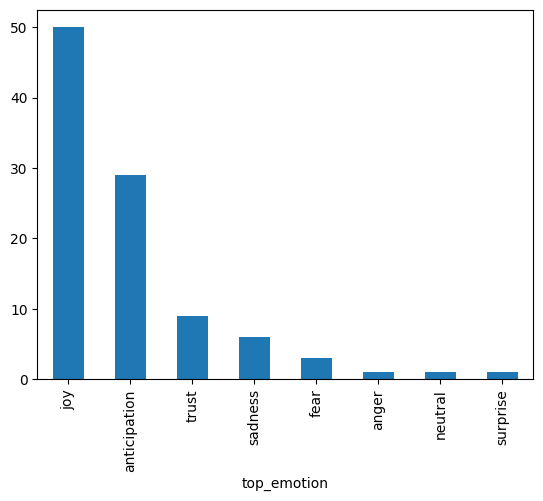

In [13]:
import matplotlib.pyplot as plt
batch_result['top_emotion'].value_counts().plot(kind='bar')
plt.show()